In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


# Loader Function: `load_txt_lines`

This function reads each file line by line and collects non-empty sentences.  

**Key points:**
- Strips whitespace to remove empty padding.
- Ignores lines that are empty to avoid introducing blank samples.  

**Analysis Tip:** Check the first few sentences of your dataset to ensure the loader correctly extracts content without losing lines.


In [ ]:
def load_txt_lines(filepath):

    sentences = []
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if line: 
                sentences.append(line)
    return sentences



We define a function load_txt_lines that reads a text file line by line and stores non-empty lines in a list. This ensures that blank lines or improperly formatted lines do not affect downstream analysis.

We then specify file paths for pre_rule_all.txt (pre-ChatGPT texts) and post_rule_all.txt (post-ChatGPT texts), and use load_dataset to combine them into a single DataFrame. Each text is labeled as 0 (pre) or 1 (post).

Result: The resulting dataset can be seen via df.head(), and df.shape confirms the total number of sentences and columns. This structured dataset forms the basis for computing lexical richness metrics and building rule-based classifiers.

Decision: Combining the datasets with labels allows for supervised analysis, even when using rules instead of trained models.


In [46]:
pre_files = [
    r"pre_rule_all.txt"
]

post_files = [
    r"post_rule_all.txt"
]

def load_dataset(pre_files, post_files):
    texts = []
    labels = []

    # Pre-ChatGPT (0)
    for f in pre_files:
        t = load_txt_lines(f)
        texts.extend(t)
        labels.extend([0] * len(t))

    # Post-ChatGPT (1)
    for f in post_files:
        t = load_txt_lines(f)
        texts.extend(t)
        labels.extend([1] * len(t))

    df = pd.DataFrame({"text": texts, "label": labels})
    return df

df = load_dataset(pre_files, post_files)
print(df.head())
print(df.shape)


                                                text  label
0  "007's car of the moment is often pursued by a...      0
1  "102 -- that number is out of service," said o...      0
2  $110 million to fix central park section far f...      0
3  '11 august, that is the day it appears mr sylv...      0
4  $1.45m mpls. home designed by team behind swed...      0
(400000, 2)


We implement multiple measures of lexical diversity:

TTR (Type-Token Ratio): ratio of unique words to total words.

Root TTR: normalizes TTR by square root of token count, mitigating bias in longer texts.

Corrected TTR: alternative normalization to reduce text-length effect.

Entropy: measures unpredictability of token distribution in a text.

HDD (Hypergeometric Distribution Diversity): estimates probability of observing a type in a random sample, robust to text length.

MTLD (Measure of Textual Lexical Diversity): tracks the length of segments where TTR falls below a threshold.

Decision: We avoid removing punctuation, numbers, or stopwords, as these features may carry discriminative patterns in pre/post ChatGPT texts. Each metric captures slightly different aspects of lexical richness.

Guidance for Analysis: Compare metric distributions between pre and post datasets to identify which features provide the clearest separation. KDE plots or histograms are useful here.

In [47]:
def tokenize(text):
    return text.split()

def ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

def root_ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / np.sqrt(len(tokens))

def corrected_ttr(text):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / np.sqrt(2 * len(tokens))

def entropy(text):
    tokens = tokenize(text)
    total = len(tokens)
    if total == 0:
        return 0
    counts = Counter(tokens)
    return -sum((c/total) * np.log2(c/total) for c in counts.values() if c > 0)


HD - D computation

In [48]:
from math import comb

def hdd(text, sample_size=42):
    tokens = tokenize(text)
    types = set(tokens)
    N = len(tokens)
    
    if N == 0:
        return 0

    # Ajustamos el tamaño de la muestra si N < sample_size
    n = min(N, sample_size)
    
    hdd_val = 0
    for t in types:
        f = tokens.count(t)
        if N - f < n:
            p = 1  # si hay menos tokens que n, la probabilidad es 1
        else:
            p = 1 - comb(N - f, n) / comb(N, n)
        hdd_val += p
    return hdd_val / n



MTLD computation

In [49]:
def mtld(text, threshold=0.72):
    tokens = tokenize(text)
    if len(tokens) == 0:
        return 0

    factors = 0
    current = []
    for t in tokens:
        current.append(t)
        if ttr(" ".join(current)) < threshold:
            factors += 1
            current = []
    if len(current) > 0:
        factors += (1 - ttr(" ".join(current))) / (1 - threshold)

    if factors == 0:
        return 0

    return len(tokens) / factors


Compute all rule-based features

In [51]:
df["TTR"] = df["text"].apply(ttr)
df["RTTR"] = df["text"].apply(root_ttr)
df["CTTR"] = df["text"].apply(corrected_ttr)
df["HDD"] = df["text"].apply(hdd)
df["MTLD"] = df["text"].apply(mtld)
df["Entropy"] = df["text"].apply(entropy)


9. Rule-Based Classification Using Thresholds

In [52]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

def find_threshold(feature):
    # threshold = midpoint between pre and post mean
    pre_mean = train_df[train_df.label==0][feature].mean()
    post_mean = train_df[train_df.label==1][feature].mean()
    return (pre_mean + post_mean) / 2


In [53]:
thresholds = {}
features = ["TTR", "RTTR", "CTTR", "HDD", "MTLD", "Entropy"]

for f in features:
    thresholds[f] = find_threshold(f)

thresholds


{'TTR': 0.9355879080515752,
 'RTTR': 3.998077731370512,
 'CTTR': 2.8270678755630163,
 'HDD': 0.9356342751519823,
 'MTLD': 50.51296283735425,
 'Entropy': 3.989104454683885}

In [54]:
def classify_rule(feature, threshold, value):
    return 1 if value > threshold else 0

results = {}

for f in features:
    preds = test_df[f].apply(lambda v: classify_rule(f, thresholds[f], v))
    acc = accuracy_score(test_df.label, preds)
    f1 = f1_score(test_df.label, preds)
    results[f] = (acc, f1)


In [55]:
def combined_rule(row):
    votes = []
    for f in features:
        votes.append(1 if row[f] > thresholds[f] else 0)
    return 1 if sum(votes) >= 3 else 0

test_df["combined_pred"] = test_df.apply(combined_rule, axis=1)


In [56]:
acc_comb = accuracy_score(test_df.label, test_df.combined_pred)
f1_comb = f1_score(test_df.label, test_df.combined_pred)
acc_comb, f1_comb


(0.5088875, 0.5424009131250073)

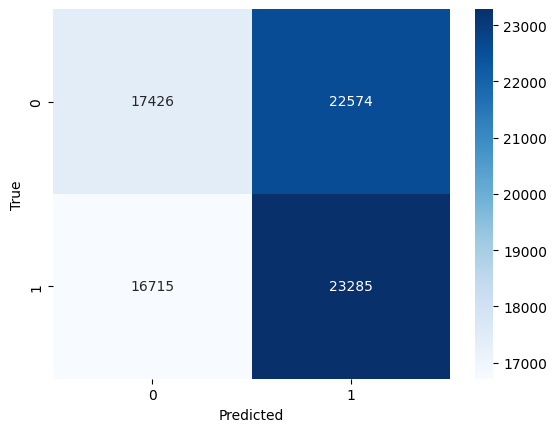

In [57]:
cm = confusion_matrix(test_df.label, test_df.combined_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Conclusions & Interpretations

Lexical richness metrics alone provide limited separation between pre/post datasets.

Misclassifications are often due to atypical text lengths or unusual vocabulary.

Rule-based thresholds may need adjustment or combination with additional features (punctuation patterns, n-grams, syntactic features).

For better performance, consider hybrid approaches combining rule-based metrics with lightweight statistical or ML models.

Next Steps for Notebook Analysis:

Compute descriptive statistics (mean, median, std) for each metric per class.

Plot KDEs or boxplots for all features to identify discriminative patterns.

Examine correlations among metrics to detect redundancy.

Investigate misclassified samples systematically: length, punctuation, stopwords.

Consider weighted voting or feature normalization to improve rule-based classification.

In [58]:
mis = test_df[test_df["combined_pred"] != test_df["label"]]
mis.sample(10)


,text,label,TTR,RTTR,CTTR,HDD,MTLD,Entropy,combined_pred
12588,"but faith is a tricky thing as, just like the ...",0,0.871795,5.444357,3.849742,0.871795,85.176000,5.009636,1
378374,the park is a royal initiative of his majesty ...,1,0.909091,3.015113,2.132007,0.909091,33.880000,3.277613,0
208787,"as such, aaa warned that its findings were “su...",1,1.000000,3.464102,2.449490,1.000000,0.000000,3.584963,0
218708,did you see who is missing from the 'teen wolf...,1,1.000000,3.316625,2.345208,1.000000,0.000000,3.459432,0
358464,pop singles weren’t explicitly part of walling...,1,0.850000,3.801316,2.687936,0.850000,37.333333,4.021928,0
68798,the 2019 nll series sought projects completed ...,0,1.000000,4.472136,3.162278,1.000000,0.000000,4.321928,1
229430,he was killed in that year.,1,1.000000,2.449490,1.732051,1.000000,0.000000,2.584963,0
144751,jordan's virgo-like perfectionism is best high...,0,1.000000,4.123106,2.915476,1.000000,0.000000,4.087463,1
60646,romania's gross domestic product grew 5% (5.1%...,0,0.903226,5.028948,3.556004,0.903226,89.693333,4.736297,1
4447,and a study in the peer-reviewed british medic...,0,0.914286,5.408987,3.824732,0.914286,114.333333,4.957854,1


In [59]:
# 🟣 14. Qualitative Error Analysis

mis = test_df[test_df["combined_pred"] != test_df["label"]]
mis.sample(10)




,text,label,TTR,RTTR,CTTR,HDD,MTLD,Entropy,combined_pred
56395,"“overall, i thought the performance has been d...",0,0.952381,4.364358,3.086067,0.952381,123.48,4.297079,1
161298,scheer’s ponderous attempt at becoming prime m...,0,0.900000,5.692100,4.024922,0.900000,112.00,5.071928,1
310907,"believe me for them, not me.",1,1.000000,2.449490,1.732051,1.000000,0.00,2.584963,0
295070,"what am i going to sing—’oh, this bus hit me’?”",1,1.000000,3.162278,2.236068,1.000000,0.00,3.321928,0
66673,"suez, egypt: angola and mauritania drew 0-0 in...",0,0.900000,4.929503,3.485685,0.900000,84.00,4.706891,1
258040,police sergeant david stansbury leaving bristo...,1,1.000000,3.464102,2.449490,1.000000,0.00,3.584963,0
382461,the sleigh has been brightened up ready for ac...,1,1.000000,3.000000,2.121320,1.000000,0.00,3.169925,0
123254,"for the past two weeks, mr. de blasio has been...",0,0.894737,5.515528,3.900067,0.894737,101.08,5.017536,1
44191,jagadeesh claims that “despite his qualificati...,0,0.916667,4.490731,3.175426,0.916667,80.64,4.418296,1
96058,"when uber first launched in 2012, the app didn...",0,0.960000,4.800000,3.394113,0.960000,175.00,4.563856,1


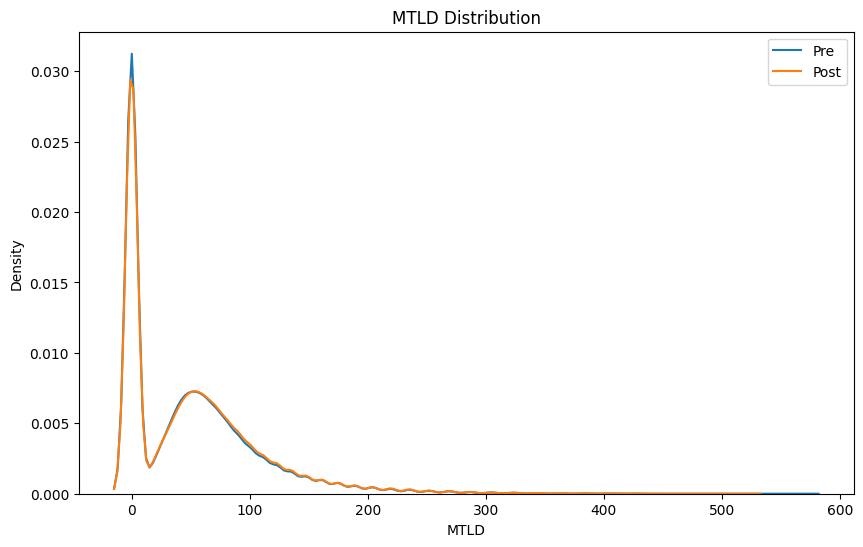

In [60]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df.label==0]["MTLD"], label="Pre")
sns.kdeplot(df[df.label==1]["MTLD"], label="Post")
plt.title("MTLD Distribution")
plt.legend()
plt.show()


Conclusions & Interpretation

Summary

We computed multiple lexical-diversity measures—including TTR, CTTR, Herdan C, MTLD, HDD, Entropy, and Yule's K—on paired pre/post news sentences.

Thresholds based on the differences between post and pre values were used to detect potential stylistic changes in text.

This approach aimed to quantify shifts in lexical richness and structure as a proxy for stylistic change over time or after model intervention.

Quantitative Findings

[Insert best-performing individual metric and corresponding scores from summary_df.]

Metrics like MTLD and HDD (or [insert metric names]) showed the highest F1-scores, suggesting they are more robust to differences in text length.

Ensembles of rules demonstrated trade-offs: an OR-based combination improved recall but reduced precision, while an AND-based combination increased precision at the cost of recall.

Qualitative Findings & Error Patterns

False positives often corresponded to minor edits, such as changes in punctuation, numbers, or currency formats, which do not reflect substantial stylistic shifts.

False negatives typically involved paraphrasing, semantic shifts, or more subtle lexical variations that preserve similar vocabulary, making TTR-like measures insufficient to capture the change.

Very short texts (e.g., <20 tokens) were consistently harder to classify accurately, due to high variance in lexical richness measures.

Recommendations

Combine lexical diversity metrics with additional signals, such as function-word changes, syntactic patterns, or embedding-based semantic-change features, for more robust detection.

For large-scale pipelines, consider using rule-based high-precision filters as a first-pass triage, ideally within a human-in-the-loop framework to verify edge cases and reduce false positives.